# Change-point model

Consider the following model: 
\begin{equation*}
   y_t = \beta_0 + \beta_1 I\{t > c\} + \epsilon_t.
\end{equation*}
This is known as a change-point model. The parameter $c$ is called the change-point. $I\{t > c\}$ is the **indicator** function which takes the value 1 if $t > c$ and 0 otherwise. The function $\beta_0 + \beta_1 I\{t > c\}$ equals $\beta_0$ for times $t \leq c$ and equals $\beta_0 + \beta_1$ for times $t > c$. Therefore this model states that the level of the time series equals $\beta_0$ until a time $c$ at which point it switches to $\beta_0 + \beta_1$. The value of $c$ is therefore called the changepoint. From the given data $y_1, \dots, y_n$, we need to infer the parameter $c$ as well as $\beta_0, \beta_1, \sigma$. The unknown parameter $c$ makes it a nonlinear model. If $c$ were known, this will become a linear regression model with $X$-matrix given by
\begin{equation*}
    X_c = \begin{pmatrix} 1 & I\{1 > c\} \\ 1 & I\{2 > c\} \\ 1 & I\{3 > c\} \\ \cdot & \cdot \\ \cdot & \cdot \\ \cdot & \cdot \\ 1 & I\{n > c\} \end{pmatrix}
\end{equation*}

For parameter estimation and inference, we first compute RSS($c$): 
\begin{equation*}
    RSS(c) := \min_{\beta_0, \beta_1} \sum_{t=1}^n (y_t - \beta_0 - \beta_1 I\{t > c\})^2
\end{equation*}
and then minimize over $c$ to obtain the MLE of $\hat{c}$. After finding $\hat{c}$, we can find the MLEs of the other parameters as in linear regression with known $c$. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Here is a simulated dataset having a change point:
n = 10000
mu1 = 0
mu2 = 0.4
dt = np.concatenate([np.repeat(mu1, n/2), np.repeat(mu2, n/2)])
sig = 1

rng = np.random.default_rng(seed = 42)
errorsamples = rng.normal(loc = 0, scale = sig, size = n)

y = dt + errorsamples

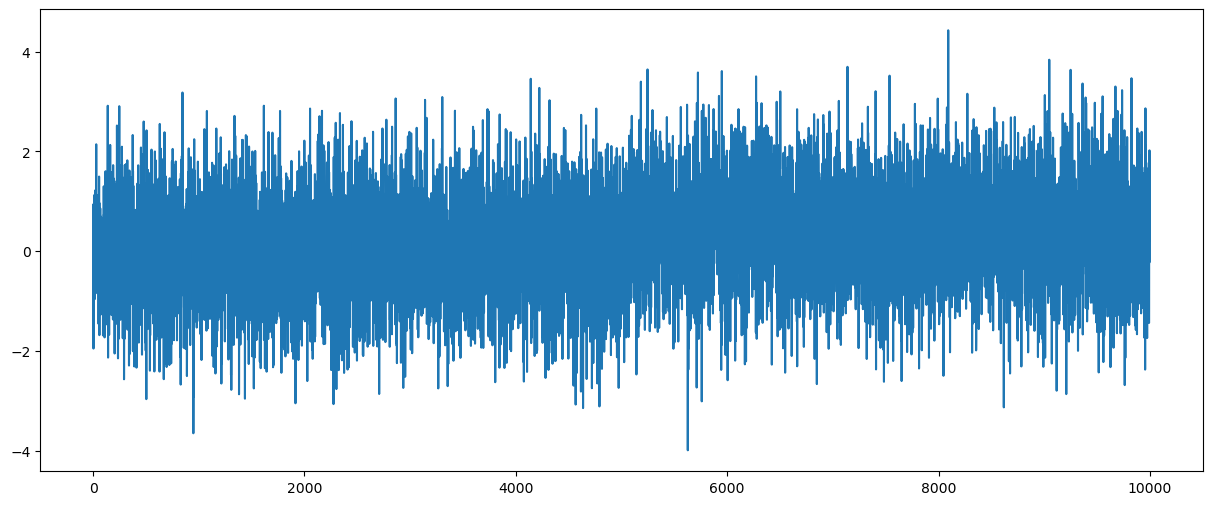

In [3]:
plt.figure(figsize = (15, 6))
plt.plot(y)
plt.show()

In [4]:
def rss(c):
    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    
    return rss

In [5]:
allcvals = np.arange(1, n)
rssvals = np.array([rss(c) for c in allcvals])

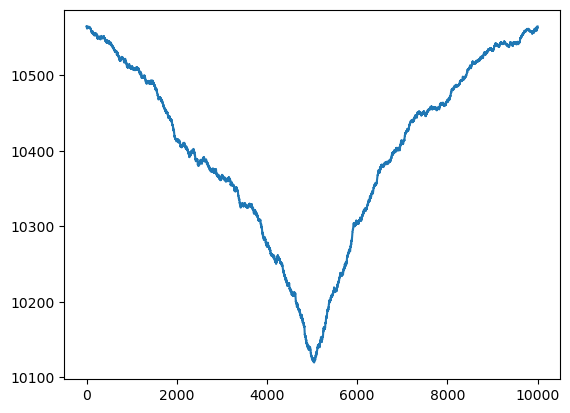

In [6]:
plt.plot(allcvals, rssvals)
plt.show()

In [7]:
c_hat = allcvals[np.argmin(rssvals)]
print(c_hat)

5045


In [8]:
# Estimates of other parameters: 
x = np.arange(1, n + 1)
c = c_hat
xc = (x > c).astype(float)

X = np.column_stack([np.ones(n), xc])
md = sm.OLS(y, X).fit()

print(md.params) # this gives estimates of beta_0, beta_1 (compare them to the true values which generated the data)

b0_est = md.params[0]
b1_est = md.params[1]

b0_true = mu1
b1_true = mu2 - mu1

print(np.column_stack((np.array([b0_est, b1_est]), np.array([b0_true, b1_true]))))

rss_chat = np.sum(md.resid ** 2)
sigma_mle = np.sqrt(rss_chat / n)
sigma_unbiased = np.sqrt(rss_chat / (n - 2))

print(np.array([sigma_mle, sigma_unbiased, sig])) #sig is the true value of sigma which generated the data

[-0.01930042  0.42189817]
[[-0.01930042  0.        ]
 [ 0.42189817  0.4       ]]
[1.00596521 1.00606582 1.        ]


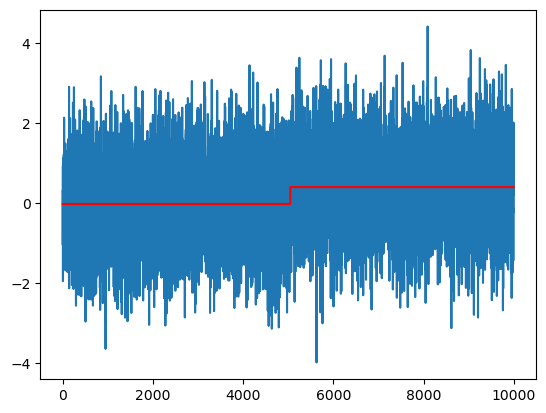

In [9]:
# Plotting the fitted values:
plt.plot(y)
plt.plot(md.fittedvalues, color = 'red')

The Bayesian posterior for $c$ is:
\begin{equation*}
 |X_c^T X_c|^{-1/2} \left(\frac{1}{RSS(c)} \right)^{(n-p)/2}
\end{equation*}
where $p = 2$ and $|X_c^T X_c|$ denotes the determinant of $X_c^T X_c$. 

As before, it is better to compute the logarithm of the posterior (as opposed to the posterior directly) because of numerical issues. 

In [10]:
def logpost(c):
    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])
    p = X.shape[1]

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)
    sgn, log_det = np.linalg.slogdet(np.dot(X.T, X)) 
    # sgn gives the sign of the determinant (in our case, this should 1)
    # log_det gives the logarithm of the absolute value of the determinant

    logval = ((p - n) / 2) * np.log(rss) - 0.5 * log_det

    return logval

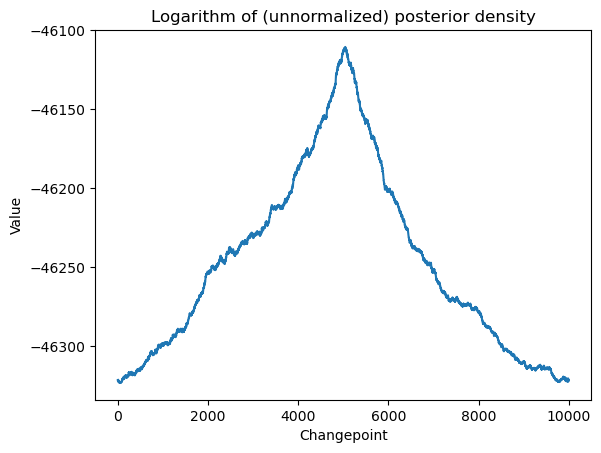

In [11]:
allcvals = np.arange(1, n)
logpostvals = np.array([logpost(c) for c in allcvals])

plt.plot(allcvals, logpostvals)
plt.xlabel('Changepoint')
plt.ylabel('Value')
plt.title('Logarithm of (unnormalized) posterior density')
plt.show() 
# this plot looks similar to the RSS plot

Let us exponentiate the log-posterior values to get the posterior. 

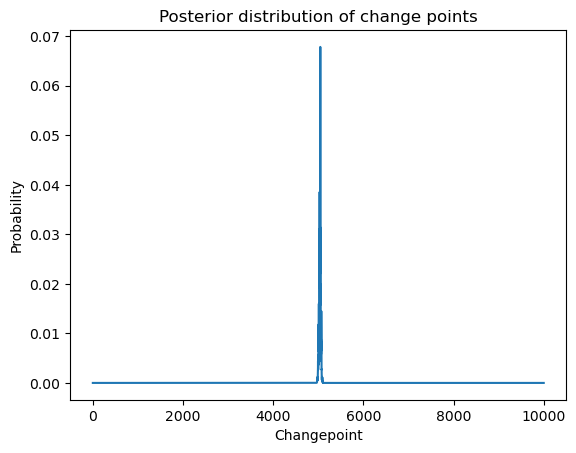

In [12]:
postvals_unnormalized = np.exp(logpostvals - np.max(logpostvals))
postvals = postvals_unnormalized / (np.sum(postvals_unnormalized))

plt.plot(allcvals, postvals)
plt.xlabel('Changepoint')
plt.ylabel('Probability')
plt.title('Posterior distribution of change points')
plt.show()

The following code generates posterior samples. 

In [ ]:
N = 2000
cpostsamples = rng.choice(allcvals, N, replace = True, p = postvals)
post_samples = np.zeros(shape = (N, 4))
post_samples[:,0] = cpostsamples

for i in range(N):
    c = cpostsamples[i]

    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])
    p = X.shape[1]

    md_c = sm.OLS(y, X).fit()

    chirv = rng.chisquare(df = n - p)
    sig_sample = np.sqrt(np.sum(md_c.resid ** 2) / chirv) #posterior sample from sigma
    post_samples[i, (p + 1)] = sig_sample

    covmat = (sig_sample ** 2) * np.linalg.inv(np.dot(X.T, X))
    beta_sample = rng.multivariate_normal(mean = md_c.params, cov = covmat, size = 1)
    post_samples[i, 1:(p + 1)] = beta_sample

print(post_samples)

[[ 5.05000000e+03 -1.28000430e-02  4.20797852e-01  1.00231554e+00]
 [ 5.02500000e+03  8.04560220e-03  4.26058253e-01  1.01677879e+00]
 [ 5.05300000e+03  7.02856193e-03  4.00933767e-01  1.00499166e+00]
 ...
 [ 5.06700000e+03 -2.11369872e-02  4.34416448e-01  9.87343752e-01]
 [ 5.01700000e+03 -3.12764767e-02  4.09694942e-01  9.93151258e-01]
 [ 5.00600000e+03  3.34638353e-03  4.09055268e-01  1.00213666e+00]]


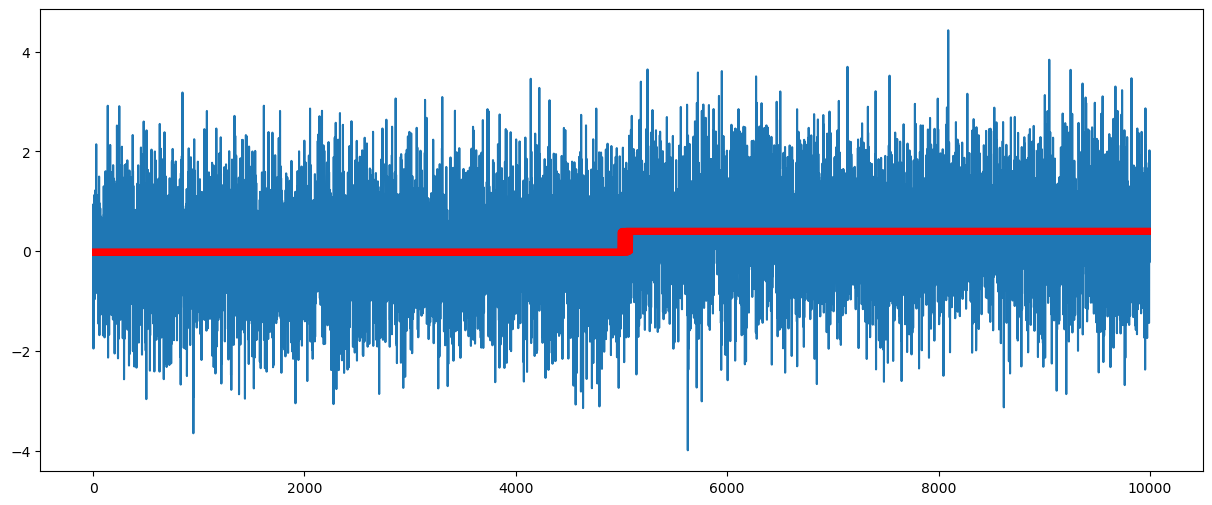

In [14]:
x = np.arange(1, n + 1)
plt.figure(figsize = (15, 6))
plt.plot(y)

for i in range(N):
    c = cpostsamples[i]
    b0 = post_samples[i, 1]
    b1 = post_samples[i, 2]

    ftdval = b0 + b1 * (x > c).astype(float)
    plt.plot(ftdval, color = 'red')

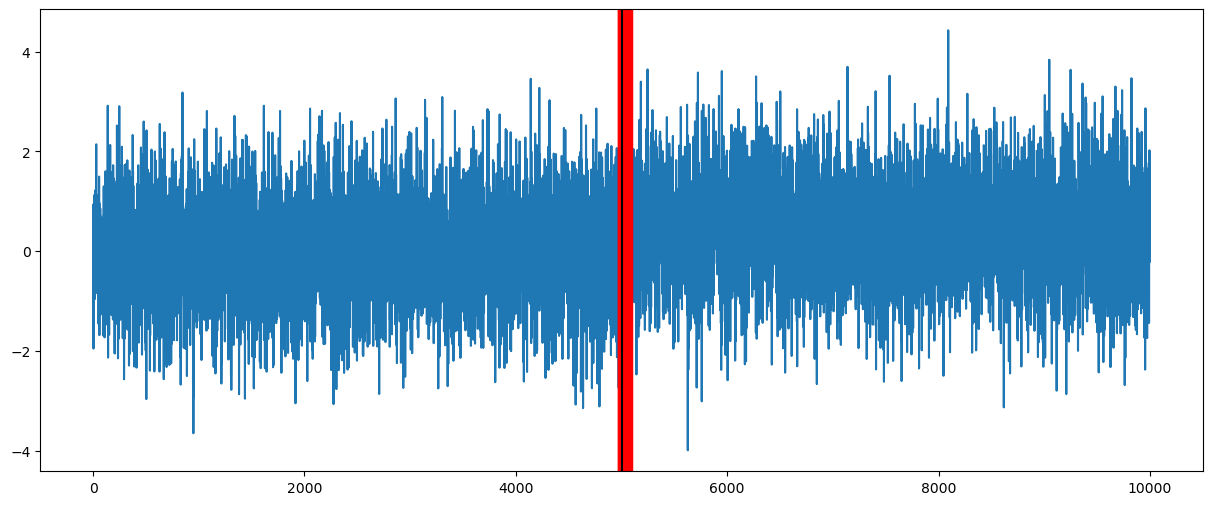

In [15]:
# Plotting only the change-point samples:
plt.figure(figsize = (15, 6))
plt.plot(y)

for i in range(N):
    c = cpostsamples[i]
    plt.axvline(c, color = 'red')

plt.axvline(5000, color = 'black') # 5000 is the true value of c
plt.show()

## Example with multiple change-points

We now consider an example where there are three change points and the model we want to use is: 
\begin{equation*}
   y_t = \beta_0 + \beta_1 I\{t > c_1\} + \beta_2 I\{t > c_2\} + \beta_3 I\{t > c_3\} + \epsilon_t
\end{equation*}
We work on a simulated dataset that is generated as follows. 

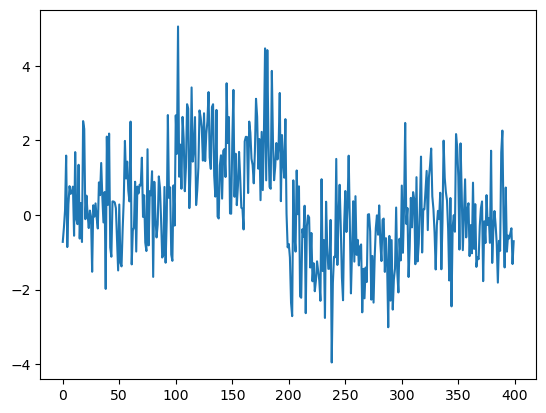

[100 200 300]


In [16]:
sig = 1
mu1 = 0
mu2 = 1.5
mu3 = -1
mu4 = 0

truedt = np.concatenate((np.repeat(mu1, 100), np.repeat(mu2, 100), np.repeat(mu3, 100), np.repeat(mu4, 100)), axis = None)
n = len(truedt)
noise = rng.normal(size = n)

y = truedt + sig * noise

plt.plot(y)
plt.show()

cps_true = np.array([100, 200, 300]) # these are true changepoints
print(cps_true)

The following is the RSS for fitting three change points to the data. 

In [17]:
def rss(c):
    n = len(y)
    x = np.arange(1, n + 1)
    X = np.column_stack([np.ones(n)])

    if np.isscalar(c):
        c = [c]

    for j in range(len(c)):
        xc = ((x > c[j]).astype(float))
        X = np.column_stack([X, xc])

    md = sm.OLS(y, X).fit()
    ans = np.sum(md.resid ** 2)

    return ans

In [ ]:
c1_gr = np.arange(75, 126)
c2_gr = np.arange(175, 226)
c3_gr = np.arange(275, 326)
X, Y, Z = np.meshgrid(c1_gr, c2_gr, c3_gr)

g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten(), 'z': Z.flatten()})
g['rss'] = g.apply(lambda row: rss([row['x'], row['y'], row['z']]), axis = 1)
# this is taking about 49 secs to run on my laptop

In [24]:
min_row = g.loc[g['rss'].idxmin()]
print(min_row)
c_opt = np.array(min_row[: -1])

x      100.000000
y      198.000000
z      300.000000
rss    432.679714
Name: 61123, dtype: float64


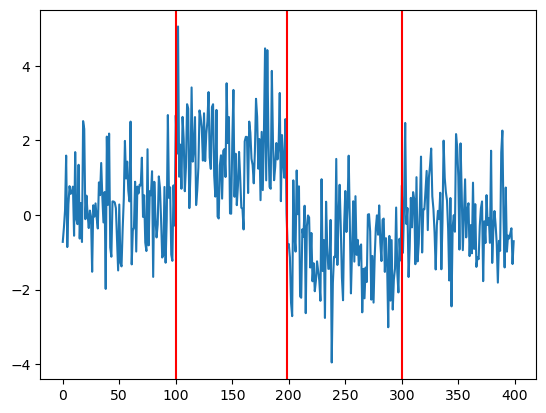

In [29]:
plt.plot(y)
plt.axvline(c_opt[0], color = 'red')
plt.axvline(c_opt[1], color = 'red')
plt.axvline(c_opt[2], color = 'red')
plt.show()

The estimates are decent. 

To obtain a faster algorithm for estimating $c_1, c_2, c_3$, we can try the following iterative algorithm. First we obtain $\hat{c}_1$ by solving single change-point RSS minimization: 
\begin{equation*}
   \hat{c}_1 = \argmin_{c_1} \min_{\beta_0, \beta_1} \sum_{t=1}^n (y_t - \beta_0 - \beta_1 I\{t > c_1\})^2. 
\end{equation*}
Then we obtain $\hat{c}_2$ by two-change point RSS minimization with the first change-point fixed at $\hat{c}_1$:
\begin{equation*}
   \hat{c}_2 = \argmin_{c_2} \min_{\beta_0, \beta_1, \beta_2} \sum_{t=1}^n (y_t - \beta_0 - \beta_1 I\{t > \hat{c}_1\} - \beta_2 I\{t > c_2\})^2. 
\end{equation*}
Finally we determine $\hat{c}_3$ by three-change point RSS minimization with the first change-point fixed at $\hat{c}_1$ and the second change-point fixed at $\hat{c}_2$:
\begin{equation*}
   \hat{c}_3 = \argmin_{c_3} \min_{\beta_0, \beta_1, \beta_2, \beta_3} \sum_{t=1}^n (y_t - \beta_0 - \beta_1 I\{t > \hat{c}_1\} - \beta_2 I\{t > \hat{c}_2\} - \beta_3 I\{t > c_3\})^2. 
\end{equation*}
Here is the algorithm. 


In [26]:
# First estimate c_1 as in the single change-point model: 
def rss(c):
    x = np.arange(1, n + 1)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

allcvals = np.arange(1, n)
rssvals = np.array([rss(c) for c in allcvals])

c1_hat = allcvals[np.argmin(rssvals)]
print(c1_hat)

198


In [27]:
# Next fix c_1 at c1_hat and estimate c_2:
def rss2(c):
    x = np.arange(1, n + 1)
    xc1hat = (x > c1_hat).astype(float)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc1hat, xc])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

allcvals = np.arange(1, n)
rss2vals = np.array([rss2(c) for c in allcvals])

c2_hat = allcvals[np.argmin(rss2vals)]
print(c2_hat)

100


In [28]:
# Finally fix c1 at c1_hat, and c2 at c2_hat and estimate c3:
def rss3(c):
    x = np.arange(1, n + 1)
    xc1hat = (x > c1_hat).astype(float)
    xc2hat = (x > c2_hat).astype(float)
    xc = (x > c).astype(float)
    X = np.column_stack([np.ones(n), xc1hat, xc2hat, xc])

    md = sm.OLS(y, X).fit()
    rss = np.sum(md.resid ** 2)

    return rss

allcvals = np.arange(1, n)
rss3vals = np.array([rss3(c) for c in allcvals])

c3_hat = allcvals[np.argmin(rss3vals)]
print(c3_hat)

300


In this example, this iterative scheme (which runs much much faster than joint grid minimization) gives the same estimates as the full grid search. 